# B20-03 Lev Kozlov

[Github link](https://github.com/lvjonok/s23-sensors/blob/master/hw5.ipynb)

## Task 1 - detect parameters of line using RANSAC algorithm

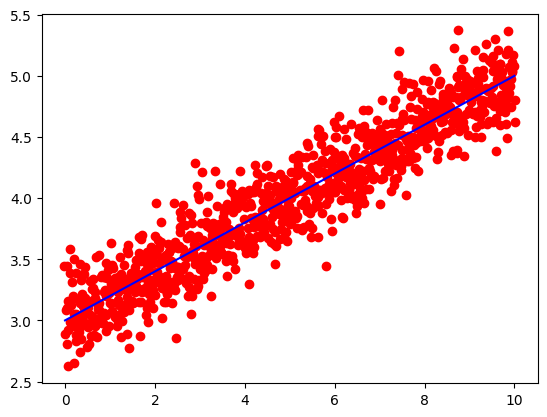

In [2]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, 10, 1000)

y = 0.2 * t + 3

# add noise
dataset = np.array([t, y])
perp = np.array([[-0.2], [3]])
perp /= np.linalg.norm(perp)
dataset_noisy = dataset + perp * np.random.normal(0, 0.2, y.shape)

plt.scatter(dataset_noisy[0], dataset_noisy[1], color='red')
plt.plot(dataset[0], dataset[1], color='blue')

In [3]:
def line(p0, p1):
    # accept two points and return a, b, c to have line in form ax + by + c = 0
    return p1[1] - p0[0], p1[0] - p0[0], p0[0] * p1[1] - p1[0] * p0[1]

def estimate_line(points):
    n = len(points)

    max_iter = 1000

    # distance to classify point as inlier
    eps = 2

    min_good_fit = 0

    iter = 0
    best_err = np.inf

    while iter < max_iter:
        maybeInliers = points[np.random.choice(list(range(len(points))), 2)]
        a, b, c = line(maybeInliers[0], maybeInliers[1])

        alsoInliers = 0
        dist_err = 0

        samples = points[np.random.choice(list(range(len(points))), int(n * 0.3))]

        normal = np.array([a, b])

        dist = np.abs(normal @ samples.T + c) / np.sqrt(normal @ normal.T)

        dist_err = np.sum(dist)
        inliers = np.count_nonzero(dist < eps)

        if inliers > min_good_fit and dist_err < best_err:
            dominantLine = (a, b, c)
            best_err = dist_err
            print(dominantLine, best_err)

        iter += 1

    return dominantLine

solution = estimate_line(dataset_noisy.T)

(-1.1845793948104566, -1.5582826347741747, 2.2449999611571023) 1499.1921602338366
(2.3147220385018894, 5.22634461298671, -14.957868980326248) 929.4251921239821
(-0.824612372067798, 2.063343599972953, -6.297527622672952) 281.5668537940012
(-1.178605715199251, 2.550471253198763, -6.259225772364182) 246.2661010590258
(-0.25949420690857217, 4.284274999607597, -15.684510515508236) 111.1585906573816
(-0.9377690619956383, 3.8542292141457137, -12.082279652234803) 103.521134381962
(0.4534606729274464, -2.442292707649192, 7.66613626141079) 53.11466234117546


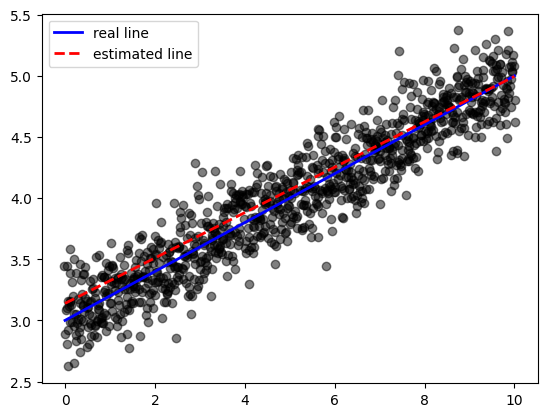

In [4]:
a, b, c = solution

new_line = -a / b * t - c / b

plt.scatter(dataset_noisy[0], dataset_noisy[1], color='black', alpha=0.5)
plt.plot(dataset[0], dataset[1], color='blue', lw=2, label='real line')
plt.plot(t, new_line, color='red', lw=2, linestyle='dashed', label='estimated line')
plt.legend()

# Task 2 - detect and visualize object from 3D point cloud

For this experiment I made a shot from Intel Realsense d435.

A small block with height 20mm placed and I plan to detect it.

## Detect & remove redundant 3D point clouds that belong to environment

I assume that points have no noise and all points belong to environment

![Alt text](hw5/presentation0.png)

![Alt text](hw5/presentation1.png)

I had to use python3.7 and conda environment to run everything

In [5]:
# !pip3 install open3d

In [6]:
import numpy as np
import open3d as o3d

cloud = o3d.io.read_point_cloud('hw5/00.ply')
points = np.asarray(cloud.points)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Detect & remove points that belong to floor using RANSAC


In [7]:
points.shape

(861658, 3)

In [8]:
np.min(points[:, 2]), np.max(points[:, 2])

(-0.6580000519752502, -0.593000054359436)

In [9]:
def plane(p0, p1, p2) -> np.ndarray:
    u, v = p1 - p0, p2 - p0
    normal = np.cross(u, v)
    normal = normal / np.linalg.norm(normal)
    d = -p0.dot(normal)

    return normal, d

plane(np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([1, 1, 0]))

(array([ 0.,  0., -1.]), -0.0)

In [10]:

def estimate_plane(points):
    n = len(points)

    max_iter = 150

    # distance to classify point as inlier
    eps = 0.005

    min_good_fit = 0

    iter = 0
    best_err = np.inf

    while iter < max_iter:
        maybeInliers = points[np.random.choice(list(range(len(points))), 3)]
        normal, d = plane(maybeInliers[0], maybeInliers[1], maybeInliers[2])

        alsoInliers = 0
        dist_err = 0

        samples = points[np.random.choice(list(range(len(points))), int(n * 0.3))]

        dist = np.abs(normal @ samples.T + d) / np.sqrt(normal @ normal.T)

        dist_err = np.sum(dist)
        inliers = np.count_nonzero(dist < eps)

        if inliers > min_good_fit and dist_err < best_err:
            dominantPlane = (normal, d)
            best_err = dist_err
            print(dominantPlane, best_err)

        iter += 1

    return dominantPlane

solution = estimate_plane(points)

(array([ 0.03535597, -0.14800193,  0.98835489]), 0.6072769252341694) 2655.0816669524324
(array([-0.00409075,  0.10410863, -0.99455752]), -0.621977972936928) 742.0782654385862
(array([ 0.01170717, -0.11137894,  0.99370905]), 0.619111705473446) 724.9015395448477
(array([ 0.00431319, -0.09851606,  0.99512611]), 0.6207026939359376) 657.7711790854484
(array([ 0.00868628, -0.1035345 ,  0.99458793]), 0.6195238653471045) 639.3360200182511
(array([ 0.00950012, -0.10069437,  0.99487205]), 0.6202660871377612) 604.7584800921917


In [11]:
normal, d = solution

# remove all points which are not on plane
inliers = np.abs((normal @ points.T + d)) / np.sqrt(normal @ normal.T)
filtered = points[inliers > 0.015] # height of cube is 0.02

filtered.shape

(1237, 3)

In [12]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(filtered)
o3d.io.write_point_cloud("hw5/filtered.ply", pcd)

True

## Find distance to object

In [13]:
minz = np.inf

for p in filtered:
    if p[2] < minz:
        minz = p[2]


print(minz)

-0.5980000495910645


As we see this distance is approximately 0.6 which is exactly as was initially

# Results

As we see in this image, cube is pretty much filtered.

![Alt text](hw5/result.png)
![Alt text](hw5/presentation0.png)

code for showing same, it will not work in jupyter notebook:

```python
import numpy as np
import open3d as o3d

def main():
    points = o3d.io.read_point_cloud('hw5/filtered.ply')
    points.paint_uniform_color(np.array([0.1, 0.1, 0.1]))
    pcd = o3d.io.read_point_cloud('hw5/00.ply')
    pcd.paint_uniform_color(np.array([1, 0.706, 0]))
    o3d.visualization.draw_geometries([pcd, points], 'Demonstration', 1080, 720)
    

if __name__ == "__main__":
    main()
```